<a href="https://colab.research.google.com/github/hcrystalwang/tutorials/blob/main/ACN_KnowledgeShare_NLP_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### NLP Tutorials 1/25/2023
- Basic Concepts
- Twitter Sarcasm
- Lyric Generation

Based on Google Tutorials

### Tokenization

In [80]:
# Tokenizer sentences -> give each words an code (or index)
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'I love my dog',
    'I Love my family'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'family': 5}


In [81]:
# Tokenizer sentences -> give each words an code (or index)
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'I love my dog',
    'I Love my family',
    'She loves her dog!'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)
sequences = tokenizer.texts_to_sequences(sentences)
print("\nSequences = " , sequences)

{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'family': 5, 'she': 6, 'loves': 7, 'her': 8}

Sequences =  [[1, 2, 3, 4], [1, 2, 3, 5], [6, 7, 8, 4]]


In [18]:
# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog',
    'He loves my dog'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)


Test Sequence =  [[1, 2, 3, 4], [7, 3, 4]]


In [19]:
# Preprocess sentences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'She loves her dog!'
]

# <OOV> out of vocabulary 
tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5) 
# maxlen defines the length of processed sentences
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)

# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ", padded)

padded = pad_sequences(test_seq, maxlen=10, padding='post')
print("\nPadded Test Sequence: ", padded)


Word Index =  {'<OOV>': 1, 'i': 2, 'love': 3, 'my': 4, 'dog': 5, 'cat': 6, 'she': 7, 'loves': 8, 'her': 9}

Sequences =  [[2, 3, 4, 5], [2, 3, 4, 6], [7, 8, 9, 5]]

Padded Sequences:
[[0 2 3 4 5]
 [0 2 3 4 6]
 [0 7 8 9 5]]

Test Sequence =  [[2, 1, 3, 4, 5]]

Padded Test Sequence:  [[0 0 0 0 0 2 1 3 4 5]]

Padded Test Sequence:  [[2 1 3 4 5 0 0 0 0 0]]


## NLP-Twitter-Sarcasm
- Tokenize Text
- Neural Network with Embedding
- Train the Model 
- Model Evaluation
- Prediction

Dataset https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

Author Gitlab: https://rishabhmisra.github.io/publications/

Each record consists of three attributes:
* bis_sarcastic: 1 if the record is sarcastic otherwise 0
* headline: the headline of the news article
* article_link: link to the original news article. Useful in collecting supplementary data

### Get the text dataset

In [82]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [83]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2023-01-25 20:36:29--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2023-01-25 20:36:29 (50.9 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [84]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

print(datastore[1])
print(len(sentences))
print(len(labels))
print(sentences[1])
print(labels[1])

{'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 'is_sarcastic': 0}
26709
26709
the 'roseanne' revival catches up to our thorny political mood, for better and worse
0


### Tokenization

In [85]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [86]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
# 20000 for training
# 6709 for testing

In [87]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

20000
75th percentile of sentence length :  73.0
90th percentile of sentence length :  84.0
99th percentile of sentence length :  111.0


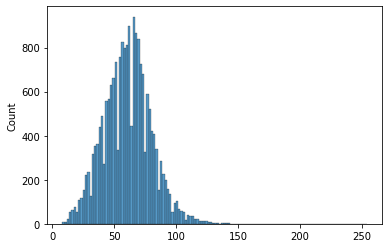

In [88]:
training_sentences_len = []
for i in training_sentences:
  training_sentences_len.append(len(i))

print(len(training_sentences_len))

import numpy as np 
import seaborn as sns
print("75th percentile of sentence length : ", np.percentile(training_sentences_len, 75))
print("90th percentile of sentence length : ", np.percentile(training_sentences_len, 90))
print("99th percentile of sentence length : ", np.percentile(training_sentences_len, 99))

sns.histplot(training_sentences_len)



### Model Training

In [89]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 24)                408       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [92]:
num_epochs = 15
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=2)

#verbose=0 will show you nothing (silent)
#verbose=1 will show you an animated progress bar like this: [======================]
#verbose=2 will show you as below

Epoch 1/15
625/625 - 3s - loss: 0.6644 - accuracy: 0.5917 - val_loss: 0.5838 - val_accuracy: 0.7573 - 3s/epoch - 5ms/step
Epoch 2/15
625/625 - 2s - loss: 0.4436 - accuracy: 0.8298 - val_loss: 0.3936 - val_accuracy: 0.8356 - 2s/epoch - 4ms/step
Epoch 3/15
625/625 - 2s - loss: 0.3217 - accuracy: 0.8748 - val_loss: 0.3568 - val_accuracy: 0.8518 - 2s/epoch - 4ms/step
Epoch 4/15
625/625 - 2s - loss: 0.2696 - accuracy: 0.8961 - val_loss: 0.3644 - val_accuracy: 0.8357 - 2s/epoch - 4ms/step
Epoch 5/15
625/625 - 2s - loss: 0.2336 - accuracy: 0.9107 - val_loss: 0.3554 - val_accuracy: 0.8486 - 2s/epoch - 4ms/step
Epoch 6/15
625/625 - 2s - loss: 0.2056 - accuracy: 0.9226 - val_loss: 0.3795 - val_accuracy: 0.8374 - 2s/epoch - 4ms/step
Epoch 7/15
625/625 - 2s - loss: 0.1824 - accuracy: 0.9326 - val_loss: 0.3579 - val_accuracy: 0.8530 - 2s/epoch - 4ms/step
Epoch 8/15
625/625 - 2s - loss: 0.1645 - accuracy: 0.9397 - val_loss: 0.3706 - val_accuracy: 0.8539 - 2s/epoch - 4ms/step
Epoch 9/15
625/625 - 2s 

### Evaluation

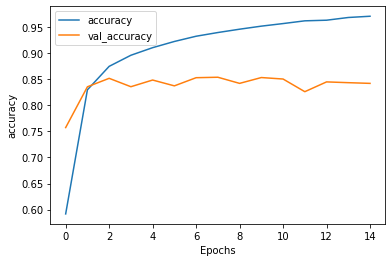

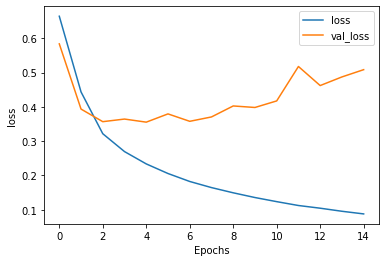

In [93]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
#val_accuracy, val_loss

#from plot it should have an early stop

In [52]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
#total 4 layers

(10000, 16)


### Prediction

In [95]:
# Now Prediction
sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night", 
            'they are really on top of things' ]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 20ms/step
[[0.8468987 ]
 [0.03280399]
 [0.50998145]]


## NLP - Lyric Generation

In [96]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [97]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2023-01-25 20:47:47--  https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2023-01-25 20:47:47 (97.5 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [98]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(len(corpus))
print(tokenizer.word_index)
print(total_words)

1693
{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 

In [99]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [76]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


377/377 [==============================] - 31s 72ms/step - loss: 6.6536 - accuracy: 0.0737
Epoch 2/100
377/377 [==============================] - 33s 88ms/step - loss: 5.7797 - accuracy: 0.1102
Epoch 3/100
377/377 [==============================] - 28s 74ms/step - loss: 4.9416 - accuracy: 0.1597
Epoch 4/100
377/377 [==============================] - 30s 79ms/step - loss: 4.0120 - accuracy: 0.2320
Epoch 5/100
377/377 [==============================] - 28s 75ms/step - loss: 3.1810 - accuracy: 0.3269
Epoch 6/100
377/377 [==============================] - 28s 74ms/step - loss: 2.5252 - accuracy: 0.4331
Epoch 7/100
377/377 [==============================] - 30s 80ms/step - loss: 2.0242 - accuracy: 0.5308
Epoch 8/100
377/377 [==============================] - 30s 80ms/step - loss: 1.6739 - accuracy: 0.6038
Epoch 9/100
377/377 [==============================] - 28s 74ms/step - loss: 1.4373 - accuracy: 0.6560
Epoch 10/100
377/377 [==============================] - 27s 72ms/step - loss: 1.2797 

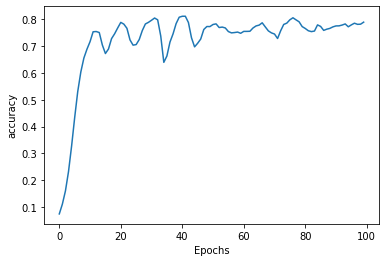

In [77]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [79]:
seed_text = "I've got a bad feeling about this"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 51ms/step
I've got a bad feeling about this she did the door and she said she had gone
